# SHACL Simple Validation

Ocean Info Hub SHACL validation examples

It should be noted here that SHACL validation is not a service OIH offers.  Rather, 
the validation is a capacity that the OIH architectural approach facilities.  Further
this validation follows W3C recommendations as describted in 
[https://www.w3.org/TR/shacl/](https://www.w3.org/TR/shacl/).

* [SHACL Playground](https://shacl.org/playground/)
* [kglab SHACL validation with pySHACL](https://derwen.ai/docs/kgl/ex5_0/)


In [2]:
import kglab as kg
from rdflib import Graph, plugin
from rdflib.serializer import Serializer

In [14]:
# set up the files we will use here
dg = './datagraphs/datagraph.json'
sg = './shapes/oih_learning.ttl'

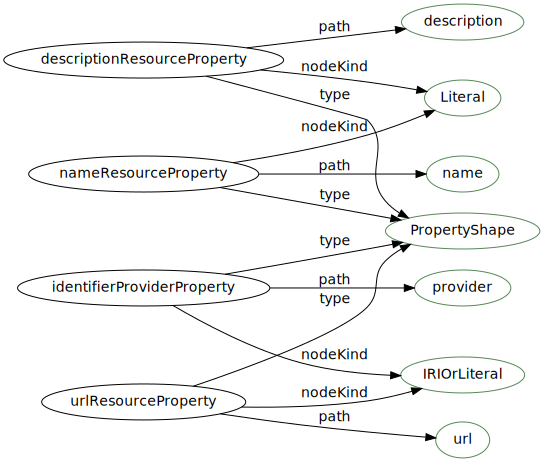

In [15]:
import json
from pyld import jsonld
import os, sys

currentdir = os.path.dirname(os.path.abspath(''))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir)
from lib import jbutils

g = Graph().parse(sg, format='ttl')

context = {"schema": "https://schema.org/", 
           "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
           "shacl": "http://www.w3.org/ns/shacl#" ,
           "oihval": "https://oceans.collaborium.io/voc/validation/1.0.1/shacl#" 
           }

sgjld = g.serialize(format='json-ld', context=context, indent=4)

doc = json.loads(sgjld)

frame = {
  "@context": {"schema": "https://schema.org/", 
           "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
           "shacl": "http://www.w3.org/ns/shacl#" ,
           "oihval": "https://oceans.collaborium.io/voc/validation/1.0.1/shacl#" 
           },
  "@explicit": "true",
  "@requireAll": "true",
  "@type":     {},
  # "shacl:message": "",
  # "shacl:targetClass": "",
  "shacl:path": "",  
  "shacl:nodeKind": "",
}

compacted = jsonld.compact(doc, context)

framed = jsonld.frame(compacted, frame)
jd = json.dumps(framed, indent=4)
# print(jd)

jbutils.show_graph(framed)

In [16]:
# pyshack sends output to log along with the vars.  This suppresses that
import logging, sys
logging.disable(sys.maxsize)

In [17]:
import kglab

namespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

kg = kglab.KnowledgeGraph(
    name = "Schema.org based datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
    )

kg.load_jsonld(dg)

In [22]:
conforms, report_graph, report_text = kg.validate(
    shacl_graph=sg,
    shacl_graph_format="ttl"
)

In [23]:
import pandas as pd
pd.set_option("max_rows", None)
        
sparql = """
SELECT ?path ?value ?constraint ?message ?id ?focus 
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""

df = report_graph.query_as_df(sparql)
df.head(10)

,path,constraint,message,id,focus,value
0,schema:provider,shacl:MinCountConstraintComponent,A provider must be noted,_:n1859c00829aa4fdcb11f5b20fc1b93cfb2,_:n1859c00829aa4fdcb11f5b20fc1b93cfb3,<NA>
1,schema:url,shacl:MinCountConstraintComponent,URL required for the location of the resource ...,_:n1859c00829aa4fdcb11f5b20fc1b93cfb4,_:n1859c00829aa4fdcb11f5b20fc1b93cfb3,<NA>
2,<NA>,shacl:NodeKindConstraintComponent,Graph must have an ID,_:n1859c00829aa4fdcb11f5b20fc1b93cfb5,_:n1859c00829aa4fdcb11f5b20fc1b93cfb3,_:n1859c00829aa4fdcb11f5b20fc1b93cfb3


In [24]:

VIS_STYLE = {
    "schema": {
        "color": "green",
        "size": 20,
    },
    "shacl":{
        "color": "red",
        "size": 20,
    },
    "_":{
        "color": "orange",
        "size": 20,
    },
}

subgraph = kglab.SubgraphTensor(report_graph)
pyvis_graph = subgraph.build_pyvis_graph(notebook=True, style=VIS_STYLE)
pyvis_graph.force_atlas_2based()
pyvis_graph.show("tmp.fig05.html")